In [61]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import random

# Task 1

### Uniform Resizing
### Color Channel Format Conversion
### Data Type and Normalization

In [62]:
def standardize_image(image, mean=None, std=None):
    if mean is None or std is None:
        mean = np.mean(image, axis=(0, 1))
        std = np.std(image, axis=(0, 1))

    # Avoid division by zero
    std = np.where(std == 0, 1e-8, std)

    standardized = (image - mean) / std
    return standardized, mean, std

def preprocess_image(image, target_size=(224, 224), use_standardization=False):
    # Resize
    resized = cv2.resize(image, target_size)

    # Convert BGR to RGB
    if len(resized.shape) == 3 and resized.shape[2] == 3:
        rgb_image = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    else:
        rgb_image = resized

    # Convert to float and normalize to [0, 1]
    normalized = rgb_image.astype(np.float32) / 255.0

    # Apply standardization
    if use_standardization:
        standardized, mean, std = standardize_image(normalized)
        return standardized, mean, std

    return normalized


# Task 2

###Noise Addition
###Noise Removal (Denoising)
###Quantitative Evaluation


In [63]:
def add_salt_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):
    noisy = image.copy()
    h, w = image.shape[:2]

    # Salt noise (white pixels)
    salt_mask = np.random.random((h, w)) < salt_prob
    if len(image.shape) == 3:
        noisy[salt_mask] = [1.0, 1.0, 1.0]  # White for all channels
    else:
        noisy[salt_mask] = 1.0

    # Pepper noise (black pixels)
    pepper_mask = np.random.random((h, w)) < pepper_prob
    if len(image.shape) == 3:
        noisy[pepper_mask] = [0.0, 0.0, 0.0]  # Black for all channels
    else:
        noisy[pepper_mask] = 0.0

    return noisy
def add_gaussian_noise(image, mean=0, sigma=0.1):
    noise = np.random.normal(mean, sigma, image.shape)
    noisy = image + noise
    noisy = np.clip(noisy, 0, 1)
    return noisy

def denoise_median(image, kernel_size=3):
    image_8bit = (image * 255).astype(np.uint8)
    denoised = cv2.medianBlur(image_8bit, kernel_size)
    return denoised.astype(np.float32) / 255.0

def denoise_gaussian(image, sigma=1.0):
    image_8bit = (image * 255).astype(np.uint8)
    ksize = int(6 * sigma) + 1
    ksize = ksize if ksize % 2 == 1 else ksize + 1
    denoised = cv2.GaussianBlur(image_8bit, (ksize, ksize), sigma)
    return denoised.astype(np.float32) / 255.0

def calculate_metrics(original, processed):
    mse = np.mean((original - processed) ** 2)
    if mse == 0:
        psnr = 100
    else:
        psnr = 20 * np.log10(1.0 / np.sqrt(mse))
    return mse, psnr


# Task 3

###Color Space Transformation
###Hue and Saturation Adjustment
###Geometric Augmentation Pipeline

In [64]:
def rgb_to_grayscale(image):
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        return gray.astype(np.float32) / 255.0
    return image

# Saturation adjustment
def adjust_saturation(image, factor=1.0):
    if len(image.shape) != 3 or image.shape[2] != 3:
        return image

    # Convert to HSV
    hsv = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    hsv = hsv.astype(np.float32)

    # Adjust saturation
    hsv[:, :, 1] = hsv[:, :, 1] * factor
    hsv[:, :, 1] = np.clip(hsv[:, :, 1], 0, 255)

    # Convert back to RGB
    hsv = hsv.astype(np.uint8)
    adjusted = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return adjusted.astype(np.float32) / 255.0

# Geometric augmentation
def geometric_augmentation(image):
    augmented = image.copy()

    # Horizontal flip (50% probability)
    if random.random() > 0.5:
        augmented = np.fliplr(augmented)

    # Random rotation (50% probability)
    if random.random() > 0.5:
        angle = random.uniform(-10, 10)
        h, w = augmented.shape[:2]
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        augmented = cv2.warpAffine((augmented * 255).astype(np.uint8), rotation_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
        augmented = augmented.astype(np.float32) / 255.0

    return augmented


# Task 4

###Sobel/Prewitt Operator
###Canny Edge Detection

In [65]:
def sobel_edge_detection(gray_image):
    # Convert to 8-bit for Sobel
    gray_8bit = (gray_image * 255).astype(np.uint8)

    # Calculate gradients
    grad_x = cv2.Sobel(gray_8bit, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray_8bit, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate magnitude
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    if magnitude.max() > 0:
        magnitude = magnitude / magnitude.max()  # Normalize to [0,1]
    else:
        magnitude = np.zeros_like(gray_image)

    return magnitude

def canny_edge_detection_experiment(gray_image, low_threshold=50, high_threshold=150, show_comparison=True, original_image=None):
    # Apply Canny with given thresholds
    edges = cv2.Canny((gray_image * 255).astype(np.uint8), low_threshold, high_threshold)
    edges_normalized = edges.astype(np.float32) / 255.0

    # Show comparison if requested
    if show_comparison and original_image is not None:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Original
        axes[0].imshow(original_image)
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        # Canny edges
        axes[1].imshow(edges_normalized, cmap='gray')
        axes[1].set_title(f'Canny Edges\nThresholds: ({low_threshold}, {high_threshold})')
        axes[1].axis('off')

        # Overlay edges on original
        overlay = original_image.copy()
        overlay[edges_normalized > 0] = [1.0, 0, 0]  # Red edges
        axes[2].imshow(overlay)
        axes[2].set_title('Edges Overlay')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

    return edges_normalized

# Function to test multiple threshold combinations
def test_canny_thresholds(gray_image, original_image):
    threshold_combinations = [
        (30, 100),   # Low thresholds - more edges, more noise
        (50, 150),   # Medium thresholds - balanced
        (100, 200),  # High thresholds - fewer edges, less noise
        (30, 200),   # Wide range
        (80, 120)    # Narrow range
    ]

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()

    # Show original
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    for i, (low, high) in enumerate(threshold_combinations):
        edges = cv2.Canny((gray_image * 255).astype(np.uint8), low, high)
        edges_normalized = edges.astype(np.float32) / 255.0

        axes[i+1].imshow(edges_normalized, cmap='gray')
        axes[i+1].set_title(f'Thresholds: ({low}, {high})\nEdges: {np.sum(edges > 0)}')
        axes[i+1].axis('off')

    # Hide empty subplot if any
    for i in range(len(threshold_combinations) + 1, 6):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def prewitt_edge_detection(gray_image):
    # Convert to 8-bit for Prewitt
    gray_8bit = (gray_image * 255).astype(np.uint8)

    # Prewitt kernels
    kernel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    kernel_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])

    # Apply Prewitt filters
    grad_x = cv2.filter2D(gray_8bit, cv2.CV_64F, kernel_x)
    grad_y = cv2.filter2D(gray_8bit, cv2.CV_64F, kernel_y)

    # Calculate magnitude
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    if magnitude.max() > 0:
        magnitude = magnitude / magnitude.max()  # Normalize to [0,1]
    else:
        magnitude = np.zeros_like(gray_image)

    return magnitude

In [66]:
def apply_processing_pipeline(image):
    results = {}

     # 0. Preprocessed (normalized to [0,1])
    preprocessed = preprocess_image(image)
    results['preprocessed'] = preprocessed

    # 1. Standardized (z-score normalized)
    standardized, mean, std = standardize_image(preprocessed)
    results['standardized'] = standardized
    results['standardization_stats'] = {'mean': mean, 'std': std}

    # 2. Grayscale
    grayscale = rgb_to_grayscale(preprocessed)
    results['grayscale'] = grayscale

    # 3. Saturation Adjusted
    saturated = adjust_saturation(preprocessed, factor=1.3)
    results['saturation_adjusted'] = saturated

    # 4. Geometric Augmented
    geometric = geometric_augmentation(preprocessed)
    results['geometric_augmented'] = geometric

    # 5. Salt & Pepper Noise
    salt_pepper = add_salt_pepper_noise(grayscale)
    mse_noise = calculate_metrics(grayscale, salt_pepper)[0]
    results['salt_pepper'] = salt_pepper
    results['salt_pepper_mse'] = mse_noise

    # 6. Median Filtered
    median_filtered = denoise_median(salt_pepper)
    mse_median = calculate_metrics(grayscale, median_filtered)[0]
    results['median_filtered'] = median_filtered
    results['median_mse'] = mse_median

    # 7. Gaussian Noise
    gaussian_noise = add_gaussian_noise(grayscale, sigma=0.05)
    mse_gaussian_noise = calculate_metrics(grayscale, gaussian_noise)[0]
    results['gaussian_noise'] = gaussian_noise
    results['gaussian_noise_mse'] = mse_gaussian_noise

    # 8. Gaussian Filtered
    gaussian_filtered = denoise_gaussian(gaussian_noise, sigma=1.0)
    mse_gaussian_filter = calculate_metrics(grayscale, gaussian_filtered)[0]
    results['gaussian_filtered'] = gaussian_filtered
    results['gaussian_filter_mse'] = mse_gaussian_filter

    # 9. Sobel Edges
    sobel_edges = sobel_edge_detection(grayscale)
    results['sobel_edges'] = sobel_edges

    # Add Prewitt edges
    prewitt_edges = prewitt_edge_detection(grayscale)
    results['prewitt_edges'] = prewitt_edges

    canny_edges = cv2.Canny((grayscale * 255).astype(np.uint8), 50, 150)
    results['canny_edges'] = canny_edges.astype(np.float32) / 255.0

    return results

Salt & Pepper MSE: 0.0059576193
Median Filter MSE: 0.0023192787
Gaussian Noise MSE: 0.002484368024690558
Gaussian Filter MSE: 0.002422116
Standardization - Mean: [0.4224204  0.34195033 0.23857778]
Standardization - Std: [0.26681486 0.18116318 0.14271611]


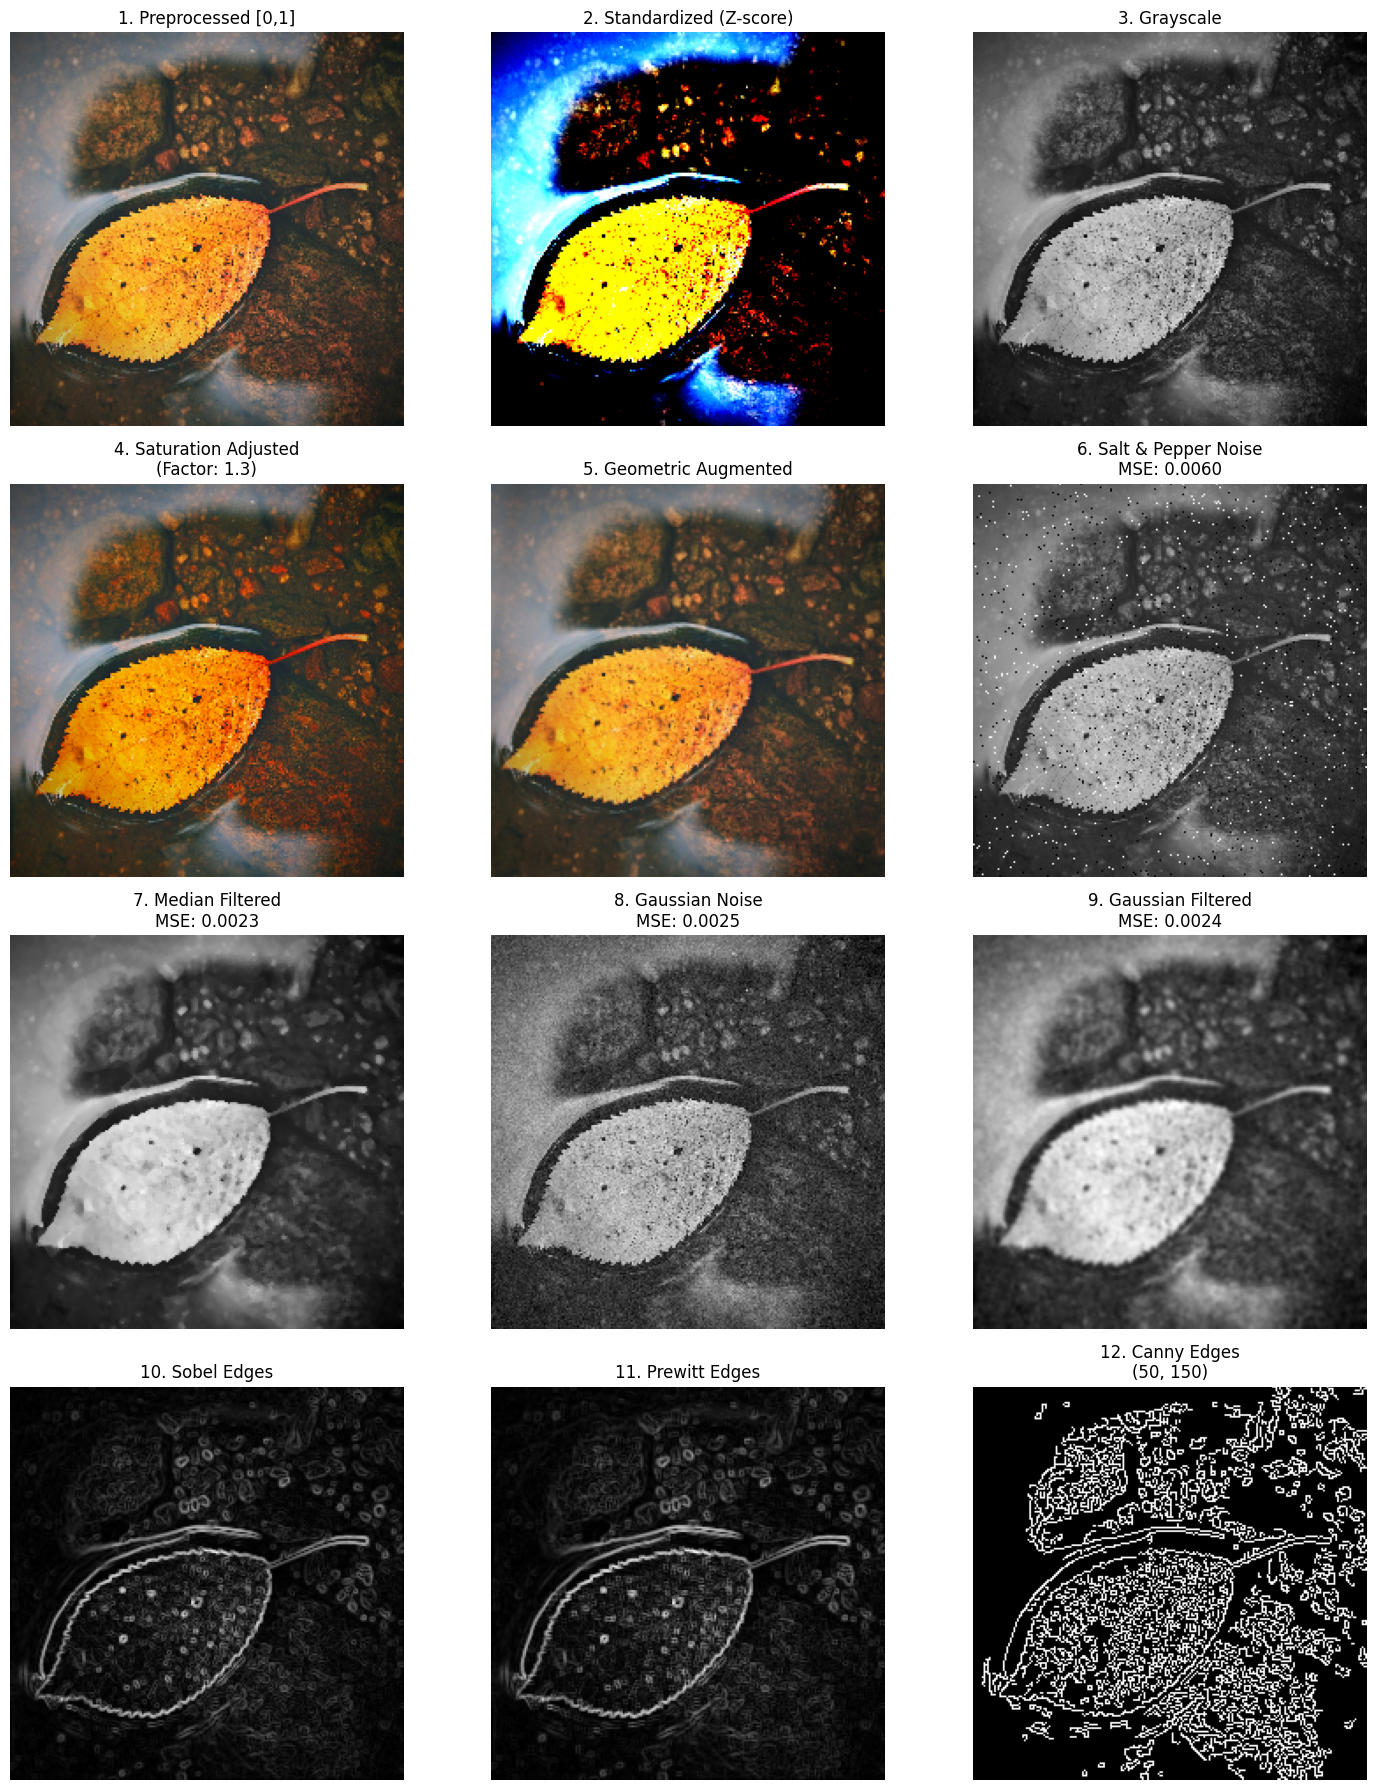


--- Canny Edge Detection Threshold Experimentation ---


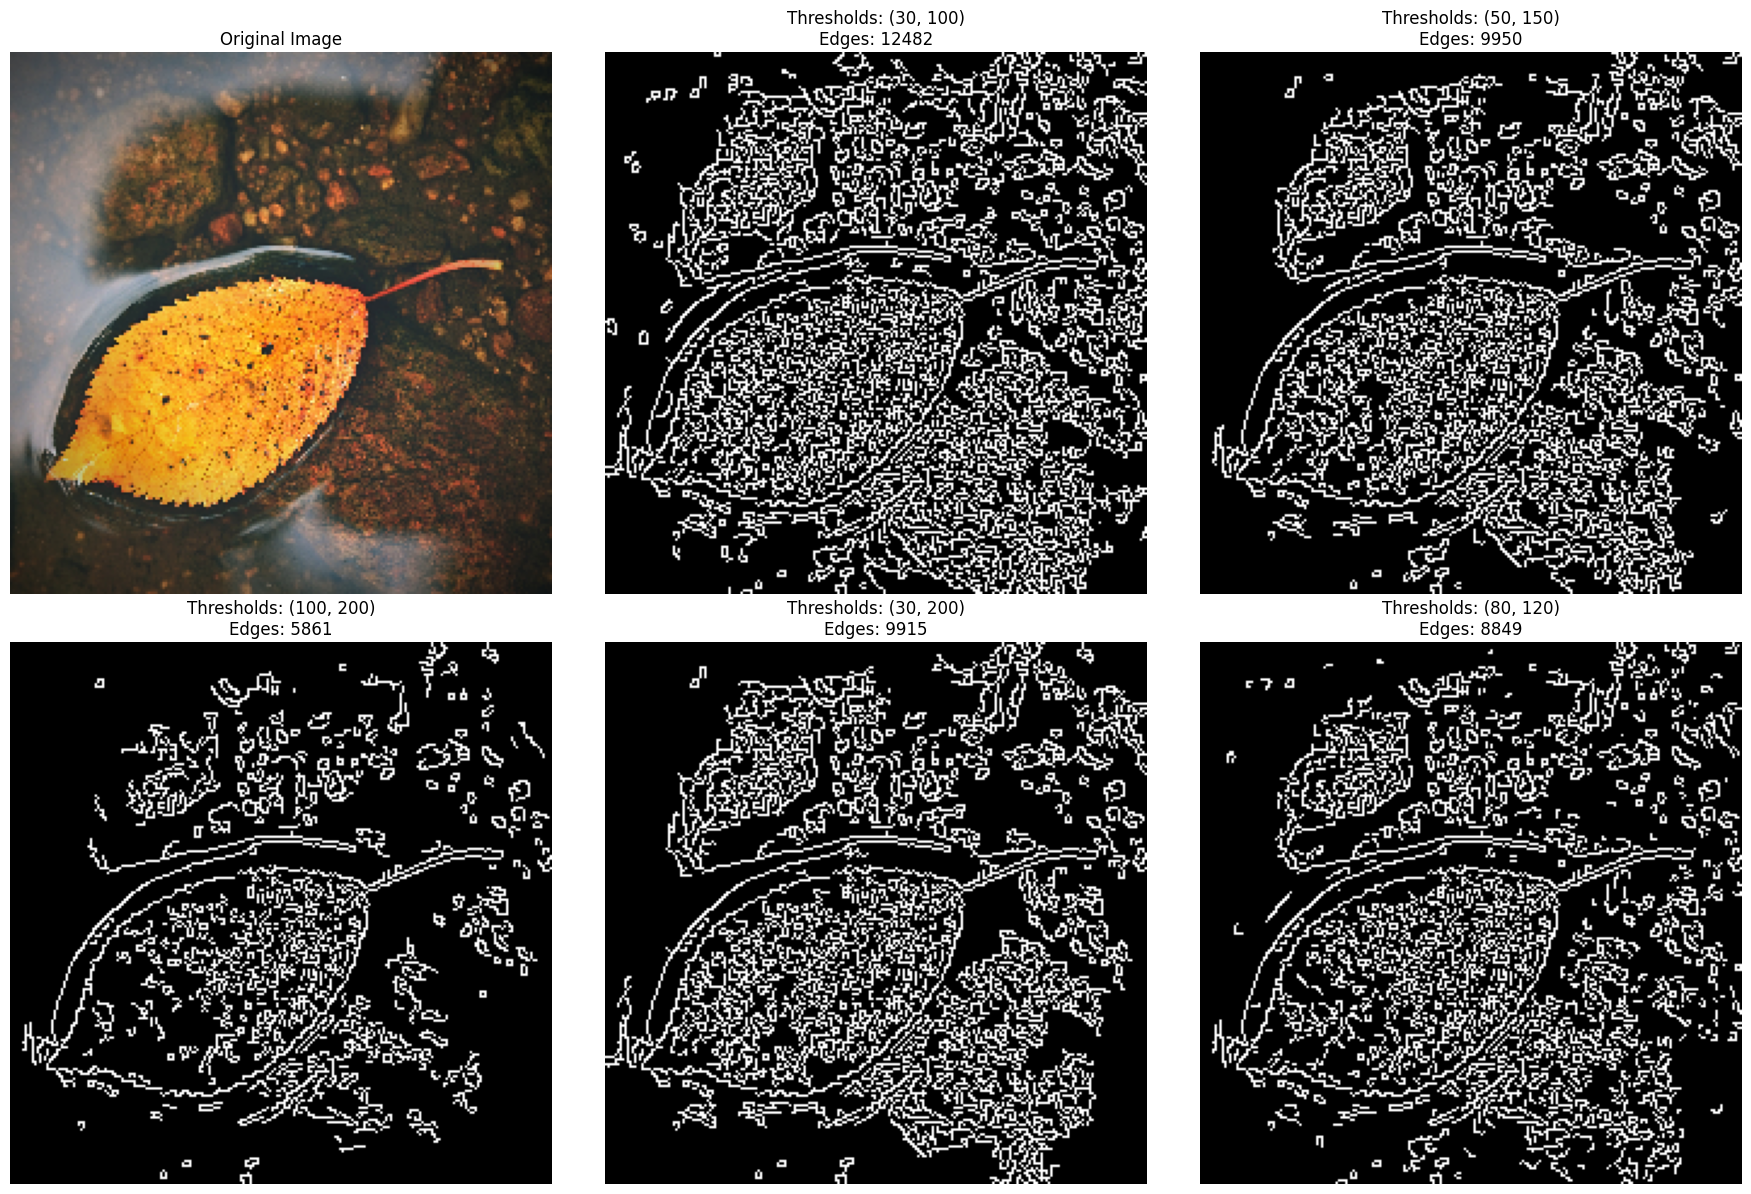

In [67]:
# Load your image
image = cv2.imread('/content/autumn-beautiful.jpg')

# Apply the complete pipeline
results = apply_processing_pipeline(image)

# Display quantitative results
print("Salt & Pepper MSE:", results['salt_pepper_mse'])
print("Median Filter MSE:", results['median_mse'])
print("Gaussian Noise MSE:", results['gaussian_noise_mse'])
print("Gaussian Filter MSE:", results['gaussian_filter_mse'])
print("Standardization - Mean:", results['standardization_stats']['mean'])
print("Standardization - Std:", results['standardization_stats']['std'])

fig, axes = plt.subplots(4, 3, figsize=(15, 18))
axes = axes.ravel()

# 1. Preprocessed
axes[0].imshow(results['preprocessed'])
axes[0].set_title('1. Preprocessed [0,1]')
axes[0].axis('off')

# 2. Standardized
axes[1].imshow(results['standardized'])
axes[1].set_title('2. Standardized (Z-score)')
axes[1].axis('off')

# 3. Grayscale
axes[2].imshow(results['grayscale'], cmap='gray')
axes[2].set_title('3. Grayscale')
axes[2].axis('off')

# 4. Saturation Adjusted
axes[3].imshow(results['saturation_adjusted'])
axes[3].set_title('4. Saturation Adjusted\n(Factor: 1.3)')
axes[3].axis('off')

# 5. Geometric Augmented
axes[4].imshow(results['geometric_augmented'])
axes[4].set_title('5. Geometric Augmented')
axes[4].axis('off')

# 6. Salt & Pepper Noise
axes[5].imshow(results['salt_pepper'], cmap='gray')
axes[5].set_title(f'6. Salt & Pepper Noise\nMSE: {results["salt_pepper_mse"]:.4f}')
axes[5].axis('off')

# 7. Median Filtered
axes[6].imshow(results['median_filtered'], cmap='gray')
axes[6].set_title(f'7. Median Filtered\nMSE: {results["median_mse"]:.4f}')
axes[6].axis('off')

# 8. Gaussian Noise
axes[7].imshow(results['gaussian_noise'], cmap='gray')
axes[7].set_title(f'8. Gaussian Noise\nMSE: {results["gaussian_noise_mse"]:.4f}')
axes[7].axis('off')

# 9. Gaussian Filtered
axes[8].imshow(results['gaussian_filtered'], cmap='gray')
axes[8].set_title(f'9. Gaussian Filtered\nMSE: {results["gaussian_filter_mse"]:.4f}')
axes[8].axis('off')

# 10. Sobel Edges
axes[9].imshow(results['sobel_edges'], cmap='gray')
axes[9].set_title('10. Sobel Edges')
axes[9].axis('off')

# 11. Prewitt Edges
axes[10].imshow(results['prewitt_edges'], cmap='gray')
axes[10].set_title('11. Prewitt Edges')
axes[10].axis('off')

# 12. Canny Edges
axes[11].imshow(results['canny_edges'], cmap='gray')
axes[11].set_title('12. Canny Edges\n(50, 150)')
axes[11].axis('off')

plt.tight_layout()
plt.show()

# SEPARATE: Show Canny threshold experimentation
print("\n--- Canny Edge Detection Threshold Experimentation ---")
test_canny_thresholds(results['grayscale'], results['preprocessed'])